In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import os
from datetime import datetime,timedelta
import rioxarray

## We will make a small cube for 13/08/2021 with the meteorological data and the closest NDVI / EVI image

In [ ]:
meteo = xr.open_dataset('meteo_nc/meteorological_data_082021.nc')

In [ ]:
selected_date = '2021-08-13'

In [ ]:
meteo

<xarray.Dataset>
Dimensions:        (longitude: 19, latitude: 16, time: 31)
Coordinates:
  * longitude      (longitude) float32 32.2 32.3 32.4 32.5 ... 33.8 33.9 34.0
  * latitude       (latitude) float32 36.0 35.9 35.8 35.7 ... 34.7 34.6 34.5
  * time           (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
Data variables:
    dom_dir        (time, latitude, longitude) float64 ...
    dom_vel        (time, latitude, longitude) float32 ...
    res_max        (time, latitude, longitude) float32 ...
    dir_max        (time, latitude, longitude) float64 ...
    max_temp       (time, latitude, longitude) float32 ...
    min_temp       (time, latitude, longitude) float32 ...
    mean_temp      (time, latitude, longitude) float32 ...
    max_dew_temp   (time, latitude, longitude) float32 ...
    min_dew_temp   (time, latitude, longitude) float32 ...
    mean_dew_temp  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [ ]:
meteo_date = meteo.sel(time = np.datetime64(selected_date))

To find the closest NDVI/EVI image we will:
<ol>
    <li>Read the filenames from the directory <b> vegetation_nc </b></li>
    <li>Add <b>15 days</b> to each date from the filename to find the <b>last day </b>processed</li>
 <li>Find the closest <b> previous </b> date of the MODIS image </li>
</ol>

![modis.jpg](attachment:modis.jpg)

In [ ]:
vegetation_path = 'vegetation_nc'

In [ ]:
list_of_files = os.listdir(vegetation_path)
list_of_files

['20210930_veg.nc',
 '20210720_veg.nc',
 '20210906_veg.nc',
 '20210728_veg.nc',
 '20210813_veg.nc',
 '20210805_veg.nc',
 '20210712_veg.nc',
 '20210922_veg.nc',
 '20210914_veg.nc',
 '20210829_veg.nc',
 '20210821_veg.nc']

## We will make a dictionary with key being the file name and value the end date

In [ ]:
veg_files_dict = {}

The command <b>'20210930_veg.nc'.split('_')</b> gives <b>['20210930', 'veg.nc']</b>

In [ ]:
for file in list_of_files:
    start_date = pd.to_datetime(file.split('_')[0]).strftime('%Y-%m-%d')
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = start_date + timedelta(days=15)
    end_date = pd.to_datetime(end_date)#.strftime('%Y-%m-%d')
    veg_files_dict[end_date] = file

In [ ]:
veg_files_dict

{Timestamp('2021-10-15 00:00:00'): '20210930_veg.nc',
 Timestamp('2021-08-04 00:00:00'): '20210720_veg.nc',
 Timestamp('2021-09-21 00:00:00'): '20210906_veg.nc',
 Timestamp('2021-08-12 00:00:00'): '20210728_veg.nc',
 Timestamp('2021-08-28 00:00:00'): '20210813_veg.nc',
 Timestamp('2021-08-20 00:00:00'): '20210805_veg.nc',
 Timestamp('2021-07-27 00:00:00'): '20210712_veg.nc',
 Timestamp('2021-10-07 00:00:00'): '20210922_veg.nc',
 Timestamp('2021-09-29 00:00:00'): '20210914_veg.nc',
 Timestamp('2021-09-13 00:00:00'): '20210829_veg.nc',
 Timestamp('2021-09-05 00:00:00'): '20210821_veg.nc'}

## Now we will find the closest date to the past - for each file we will substract the selected date from the end date to find the minimum distance

In [ ]:
v_l_list = list(veg_files_dict.keys())
closest_date = None
max_diff = timedelta(days=30)
min_diff = max_diff
for file_date in v_l_list:
    diff = pd.to_datetime(selected_date) - file_date
    diff = timedelta(days=diff.days)
    if diff.days > 0 and diff < min_diff:
        closest_date = file_date
        min_diff = diff

In [ ]:
im_path = veg_files_dict[closest_date]

In [ ]:
print(f"The closest date is {closest_date} in the file {im_path}")

The closest date is 2021-08-12 00:00:00 in the file 20210728_veg.nc


<div class="alert alert-block alert-warning"> This is the date from the above diagram! </div>

In [ ]:
vegetation = xr.open_dataset(os.path.join(vegetation_path,im_path))

## If we check closesly  vegetation and meteo arrays will we notice that:
<ol>
    <li>They have different <b> reference systems </b></li>
    <li>Different <b>spatial resolution</b>
    <li> Vegetation has one extra dimension - time</li>
</ol>

In [ ]:
vegetation

<xarray.Dataset>
Dimensions:  (x: 600, y: 500, time: 1)
Coordinates:
  * x        (x) float64 4.207e+05 4.211e+05 4.215e+05 ... 6.594e+05 6.598e+05
  * y        (y) float64 3.971e+06 3.971e+06 3.97e+06 ... 3.772e+06 3.772e+06
  * time     (time) datetime64[ns] 2021-07-28
Data variables:
    ndvi     (time, y, x) float32 ...
    evi      (time, y, x) float32 ...

In [ ]:
meteo_date

<xarray.Dataset>
Dimensions:        (longitude: 19, latitude: 16)
Coordinates:
  * longitude      (longitude) float32 32.2 32.3 32.4 32.5 ... 33.8 33.9 34.0
  * latitude       (latitude) float32 36.0 35.9 35.8 35.7 ... 34.7 34.6 34.5
    time           datetime64[ns] 2021-08-13
Data variables:
    dom_dir        (latitude, longitude) float64 ...
    dom_vel        (latitude, longitude) float32 ...
    res_max        (latitude, longitude) float32 ...
    dir_max        (latitude, longitude) float64 ...
    max_temp       (latitude, longitude) float32 ...
    min_temp       (latitude, longitude) float32 ...
    mean_temp      (latitude, longitude) float32 ...
    max_dew_temp   (latitude, longitude) float32 ...
    min_dew_temp   (latitude, longitude) float32 ...
    mean_dew_temp  (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

### 1. Delete the dimension time

In [ ]:
vegetation = vegetation.squeeze()
vegetation = vegetation.drop('time')

### 2. Reproject meteo data (first we define the source projection)

In [ ]:
source_crs = 'EPSG:4326'
meteo_date = meteo_date.rio.write_crs(source_crs)

In [ ]:
target_crs = 'EPSG:32636'
meteo_date = meteo_date.rio.reproject(target_crs)

In [ ]:
meteo_date

<xarray.Dataset>
Dimensions:        (x: 18, y: 18)
Coordinates:
  * x              (x) float64 4.269e+05 4.369e+05 ... 5.865e+05 5.964e+05
  * y              (y) float64 3.985e+06 3.975e+06 ... 3.825e+06 3.815e+06
    time           datetime64[ns] 2021-08-13
    spatial_ref    int64 0
Data variables:
    dom_dir        (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 nan
    dom_vel        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    res_max        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dir_max        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_temp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    max_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_dew_temp  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

### 3. Change the spatial resolution of meteo to match vegetation <br>
In case you want to use another spatial resolution you should build a raster with cell size equal to the desired width and values only to the land of Cyprus. In this example we will use NDVI as the model image

In [ ]:
standard_image = vegetation.ndvi.squeeze()

In [ ]:
standard_image

<xarray.DataArray 'ndvi' (y: 500, x: 600)>
[300000 values with dtype=float32]
Coordinates:
  * x        (x) float64 4.207e+05 4.211e+05 4.215e+05 ... 6.594e+05 6.598e+05
  * y        (y) float64 3.971e+06 3.971e+06 3.97e+06 ... 3.772e+06 3.772e+06
Attributes: (12/180)
    add_offset_err:                      0
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ...                                  ...
    units:                               NDVI
    valid_range:                         -2000, 10000
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              23.0940107648842
    grid_mapping:                        spatial_ref

In [ ]:
meteo_date

<xarray.Dataset>
Dimensions:        (x: 18, y: 18)
Coordinates:
  * x              (x) float64 4.269e+05 4.369e+05 ... 5.865e+05 5.964e+05
  * y              (y) float64 3.985e+06 3.975e+06 ... 3.825e+06 3.815e+06
    time           datetime64[ns] 2021-08-13
    spatial_ref    int64 0
Data variables:
    dom_dir        (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 nan
    dom_vel        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    res_max        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dir_max        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_temp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    max_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_dew_temp  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

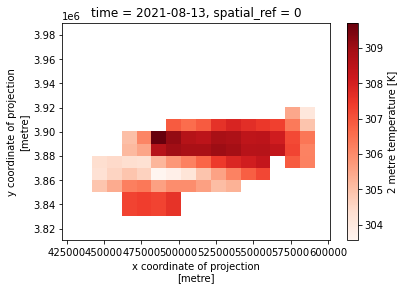

In [ ]:
meteo_date.max_temp.plot(cmap='Reds')

In [ ]:
meteo_interp = meteo_date.interp(x=standard_image["x"], y=standard_image["y"],method='nearest')

<b>The Dimensions now are the same as the standard_image's Dimensions</b>

In [ ]:
meteo_interp

<xarray.Dataset>
Dimensions:        (y: 500, x: 600)
Coordinates:
    time           datetime64[ns] 2021-08-13
    spatial_ref    int64 0
  * x              (x) float64 4.207e+05 4.211e+05 ... 6.594e+05 6.598e+05
  * y              (y) float64 3.971e+06 3.971e+06 ... 3.772e+06 3.772e+06
Data variables:
    dom_dir        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    dom_vel        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    res_max        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dir_max        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_temp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    max_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_dew_temp  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [ ]:
np.array_equal(meteo_interp.x, standard_image.x), np.array_equal(meteo_interp.y, standard_image.y)

(True, False)

<div class="alert alert-block alert-warning"> The interpolation resulted identical x,y in the datasets, <b>but</b> there are areas close to the sea that are null! </div>

In [ ]:
meteo_interp = meteo_interp.reindex(y=list(reversed(meteo_interp.y)))
for var in meteo_interp.data_vars:
    meteo_interp[var] = meteo_interp[var].interpolate_na(dim='x', method='nearest',fill_value="extrapolate")
    meteo_interp[var] = meteo_interp[var].interpolate_na(dim='y', method='nearest',fill_value="extrapolate")

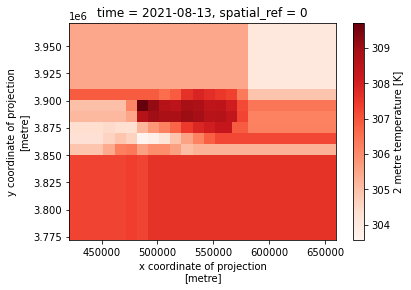

In [ ]:
meteo_interp.max_temp.plot(cmap='Reds')

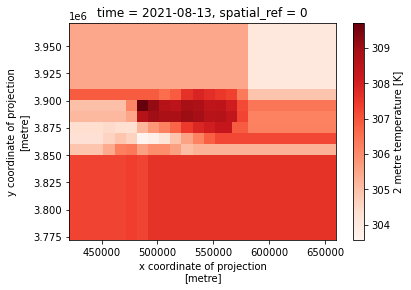

In [ ]:
meteo_interp.max_temp.plot(cmap='Reds')

In [ ]:
meteo_interp_masked = meteo_interp.where((standard_image.notnull()) & (standard_image!=0))

In [ ]:
np.array_equal(meteo_interp_masked.x, standard_image.x), np.array_equal(meteo_interp_masked.y, standard_image.y)

(True, False)

In [ ]:
meteo_interp_masked

<xarray.Dataset>
Dimensions:        (y: 500, x: 600)
Coordinates:
  * x              (x) float64 4.207e+05 4.211e+05 ... 6.594e+05 6.598e+05
  * y              (y) float64 3.772e+06 3.772e+06 ... 3.971e+06 3.971e+06
    time           datetime64[ns] 2021-08-13
    spatial_ref    int64 0
Data variables:
    dom_dir        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    dom_vel        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    res_max        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dir_max        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_temp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    max_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_dew_temp  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

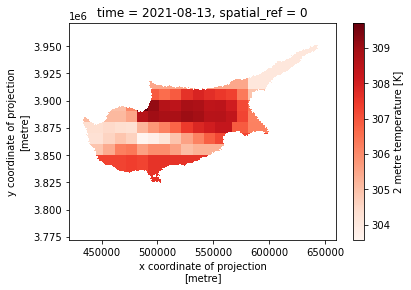

In [ ]:
meteo_interp_masked.max_temp.plot(cmap='Reds')

In [ ]:
meteo_interp_masked = meteo_interp_masked.interp(y=standard_image["y"], x=standard_image["x"],method='nearest')

In [ ]:
meteo_interp_masked

<xarray.Dataset>
Dimensions:        (y: 500, x: 600)
Coordinates:
    time           datetime64[ns] 2021-08-13
    spatial_ref    int64 0
  * y              (y) float64 3.971e+06 3.971e+06 ... 3.772e+06 3.772e+06
  * x              (x) float64 4.207e+05 4.211e+05 ... 6.594e+05 6.598e+05
Data variables:
    dom_dir        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    dom_vel        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    res_max        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dir_max        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_temp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    max_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_dew_temp  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [ ]:
np.array_equal(meteo_interp_masked.x, standard_image.x), np.array_equal(meteo_interp_masked.y, standard_image.y)

(True, True)

## Vegetation and meteo data will now be fussed in one cube

In [ ]:
meteo_interp_masked

<xarray.Dataset>
Dimensions:        (y: 500, x: 600)
Coordinates:
    time           datetime64[ns] 2021-08-13
    spatial_ref    int64 0
  * y              (y) float64 3.971e+06 3.971e+06 ... 3.772e+06 3.772e+06
  * x              (x) float64 4.207e+05 4.211e+05 ... 6.594e+05 6.598e+05
Data variables:
    dom_dir        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    dom_vel        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    res_max        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dir_max        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_temp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    max_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_dew_temp  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 17:34:35 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [ ]:
final = xr.merge([vegetation,meteo_interp_masked])

In [ ]:
final

<xarray.Dataset>
Dimensions:        (x: 600, y: 500)
Coordinates:
  * x              (x) float64 4.207e+05 4.211e+05 ... 6.594e+05 6.598e+05
  * y              (y) float64 3.971e+06 3.971e+06 ... 3.772e+06 3.772e+06
    time           datetime64[ns] 2021-08-13
    spatial_ref    int64 0
Data variables:
    ndvi           (y, x) float32 ...
    evi            (y, x) float32 ...
    dom_dir        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    dom_vel        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    res_max        (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    dir_max        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    max_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_temp       (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_temp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    max_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    min_dew_temp   (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_dew_temp  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
final = final.expand_dims('time')

In [ ]:
final

<xarray.Dataset>
Dimensions:        (x: 600, y: 500, time: 1)
Coordinates:
  * x              (x) float64 4.207e+05 4.211e+05 ... 6.594e+05 6.598e+05
  * y              (y) float64 3.971e+06 3.971e+06 ... 3.772e+06 3.772e+06
  * time           (time) datetime64[ns] 2021-08-13
    spatial_ref    int64 0
Data variables:
    ndvi           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    evi            (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    dom_dir        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    dom_vel        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    res_max        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    dir_max        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    max_temp       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    min_temp       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    mean_temp      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    max_dew_temp   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    min_dew_temp   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    mean_dew_temp  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [ ]:
final['ndvi'] = final['ndvi']*0.0001
final['evi'] = final['evi']*0.0001

In [ ]:
final.to_netcdf(f'daily_files/daily_{selected_date}.nc')

## We will now generate a daily csv <du>
    For more information about pandas https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

In [ ]:
csv = final.to_dataframe()

In [ ]:
csv

ndvi  evi  dom_dir  dom_vel  res_max  \
x             y            time                                               
420700.764597 3.971295e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.970895e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.970496e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.970097e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.969698e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
...                                     ...  ...      ...      ...      ...   
659839.259383 3.773676e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.773277e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.772877e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.772478e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   
              3.772079e+06 2021-08-13   NaN  NaN      NaN      NaN      NaN   

                                       dir_max  max_temp  min_temp  mean_temp  \
x             y            time                                                 
420700.764597 3.971295e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.970895e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.970496e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.970097e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.969698e+06 2021-08-13      NaN       NaN       NaN        NaN   
...                                        ...       ...       ...        ...   
659839.259383 3.773676e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.773277e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.772877e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.772478e+06 2021-08-13      NaN       NaN       NaN        NaN   
              3.772079e+06 2021-08-13      NaN       NaN       NaN        NaN   

                                       max_dew_temp  min_dew_temp  \
x             y            time                                     
420700.764597 3.971295e+06 2021-08-13           NaN           NaN   
              3.970895e+06 2021-08-13           NaN           NaN   
              3.970496e+06 2021-08-13           NaN           NaN   
              3.970097e+06 2021-08-13           NaN           NaN   
              3.969698e+06 2021-08-13           NaN           NaN   
...                                             ...           ...   
659839.259383 3.773676e+06 2021-08-13           NaN           NaN   
              3.773277e+06 2021-08-13           NaN           NaN   
              3.772877e+06 2021-08-13           NaN           NaN   
              3.772478e+06 2021-08-13           NaN           NaN   
              3.772079e+06 2021-08-13           NaN           NaN   

                                       mean_dew_temp  spatial_ref  
x             y            time                                    
420700.764597 3.971295e+06 2021-08-13            NaN            0  
              3.970895e+06 2021-08-13            NaN            0  
              3.970496e+06 2021-08-13            NaN            0  
              3.970097e+06 2021-08-13            NaN            0  
              3.969698e+06 2021-08-13            NaN            0  
...                                              ...          ...  
659839.259383 3.773676e+06 2021-08-13            NaN            0  
              3.773277e+06 2021-08-13            NaN            0  
              3.772877e+06 2021-08-13            NaN            0  
              3.772478e+06 2021-08-13            NaN            0  
              3.772079e+06 2021-08-13            NaN            0  

[300000 rows x 13 columns]

In [ ]:
csv.shape

(300000, 16)

In [ ]:
csv = csv.reset_index()
csv

,x,y,time,ndvi,evi,dom_dir,dom_vel,res_max,dir_max,max_temp,min_temp,mean_temp,max_dew_temp,min_dew_temp,mean_dew_temp,spatial_ref
0,420700.764597,3.971295e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,420700.764597,3.970895e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,420700.764597,3.970496e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,420700.764597,3.970097e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,420700.764597,3.969698e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,659839.259383,3.773676e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
299996,659839.259383,3.773277e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
299997,659839.259383,3.772877e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
299998,659839.259383,3.772478e+06,2021-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


There is a lot of missing values. Let's see below that actually a single column mostly contain missing values

In [ ]:
csv.isnull().sum()

x                     0
y                     0
time                  0
ndvi             241834
evi              241834
dom_dir          241840
dom_vel          241840
res_max          241840
dir_max          241840
max_temp         241840
min_temp         241840
mean_temp        241840
max_dew_temp     241840
min_dew_temp     241840
mean_dew_temp    241840
spatial_ref           0
dtype: int64

In [ ]:
csv_nona = csv.dropna()
csv_nona

,x,y,time,ndvi,evi,dom_dir,dom_vel,res_max,dir_max,max_temp,min_temp,mean_temp,max_dew_temp,min_dew_temp,mean_dew_temp,spatial_ref
15730,433076.880354,3.879472e+06,2021-08-13,0.2469,1102.0,0.0,2.879794,3.292698,8.0,304.362183,298.916260,301.834991,304.362183,298.916260,301.834991,0
16230,433476.109895,3.879472e+06,2021-08-13,0.2469,1102.0,0.0,2.879794,3.292698,8.0,304.362183,298.916260,301.834991,304.362183,298.916260,301.834991,0
16721,433875.339435,3.883065e+06,2021-08-13,0.3264,1566.0,0.0,2.849050,3.349281,8.0,305.122314,297.612457,301.277100,305.122314,297.612457,301.277100,0
16722,433875.339435,3.882666e+06,2021-08-13,0.2953,1441.0,0.0,2.849050,3.349281,8.0,305.122314,297.612457,301.277100,305.122314,297.612457,301.277100,0
16723,433875.339435,3.882266e+06,2021-08-13,0.2418,1351.0,0.0,2.849050,3.349281,8.0,305.122314,297.612457,301.277100,305.122314,297.612457,301.277100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278552,643071.618680,3.950535e+06,2021-08-13,0.4326,2534.0,0.0,3.578547,6.131804,7.0,304.081329,301.251160,302.834839,304.081329,301.251160,302.834839,0
278553,643071.618680,3.950135e+06,2021-08-13,0.5853,1812.0,0.0,3.578547,6.131804,7.0,304.081329,301.251160,302.834839,304.081329,301.251160,302.834839,0
278557,643071.618680,3.948538e+06,2021-08-13,0.5225,224.0,0.0,3.578547,6.131804,7.0,304.081329,301.251160,302.834839,304.081329,301.251160,302.834839,0
278558,643071.618680,3.948139e+06,2021-08-13,0.5578,1515.0,0.0,3.578547,6.131804,7.0,304.081329,301.251160,302.834839,304.081329,301.251160,302.834839,0


In [ ]:
csv_nona.shape

(58160, 16)

Let's check the columns

In [ ]:
csv_nona.columns

Index(['x', 'y', 'time', 'ndvi', 'evi', 'dom_dir', 'dom_vel', 'res_max',
       'dir_max', 'max_temp', 'min_temp', 'mean_temp', 'max_dew_temp',
       'min_dew_temp', 'mean_dew_temp', 'spatial_ref'],
      dtype='object')

In [ ]:
csv_nona.describe()

,x,y,ndvi,evi,dom_dir,dom_vel,res_max,dir_max,max_temp,min_temp,mean_temp,max_dew_temp,min_dew_temp,mean_dew_temp,spatial_ref
count,58160.000000,5.816000e+04,58160.0,58160.0,58160.000000,58160.000000,58160.000000,58160.000000,58160.000000,58160.000000,58160.000000,58160.000000,58160.000000,58160.000000,58160.0
mean,520845.538508,3.879114e+06,29863002.0,18706324.0,5.285660,3.094301,3.556320,6.197524,306.448853,299.075928,302.663818,306.448853,299.075928,302.663818,0.0
std,44585.400087,2.403010e+04,11993194.0,5424087.5,3.079711,1.004389,1.151169,1.974201,1.586255,1.590179,1.311874,1.586255,1.590179,1.311874,0.0
min,433076.880354,3.824777e+06,-15550000.0,-8550000.0,0.000000,0.837979,1.651127,1.000000,303.557434,294.897858,299.023651,303.557434,294.897858,299.023651,0.0
25%,486573.638787,3.860708e+06,20440000.0,14690000.0,2.000000,2.399407,2.852738,6.000000,305.122314,298.272705,301.834991,305.122314,298.272705,301.834991,0.0
50%,518112.772490,3.877476e+06,27170000.0,18220000.0,7.000000,2.890221,3.532828,7.000000,306.577454,299.354248,302.973236,306.577454,299.354248,302.973236,0.0
75%,553244.972058,3.895441e+06,36330000.0,22230000.0,8.000000,3.659389,4.305750,7.000000,307.611633,300.294006,303.779877,307.611633,300.294006,303.779877,0.0
max,643071.618680,3.951333e+06,77670000.0,44530000.0,8.000000,5.418316,6.131804,8.000000,309.712006,301.551117,305.167084,309.712006,301.551117,305.167084,0.0


In [ ]:
csv_nona.dtypes

x                       float64
y                       float64
time             datetime64[ns]
ndvi                    float32
evi                     float32
dom_dir                 float64
dom_vel                 float32
res_max                 float32
dir_max                 float64
max_temp                float32
min_temp                float32
mean_temp               float32
max_dew_temp            float32
min_dew_temp            float32
mean_dew_temp           float32
spatial_ref               int64
dtype: object

We will also remove useless columns

In [ ]:
csv = csv.drop(['spatial_ref'], axis=1)

dom_dir and dir_max are categorical variables, so we will check the unique values

In [ ]:
csv_nona['dom_dir'].unique()

array([0., 1., 8., 7., 2., 6., 5.])

In [ ]:
csv_nona['dir_max'].unique()

array([8., 7., 6., 1., 5.])

Let's check the data distribution with some histograms

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context("notebook", font_scale=1.2)

Text(0.5, 1.0, 'Histogram of NDVI')

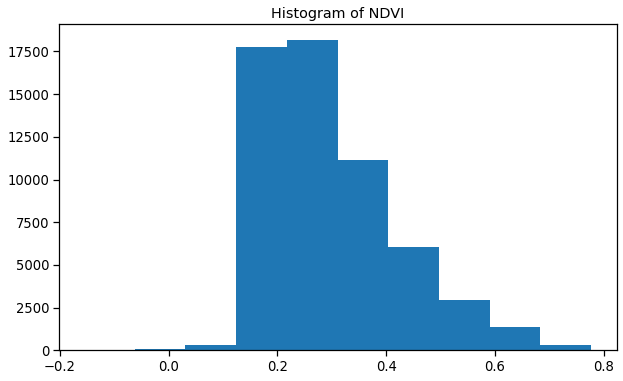

In [ ]:
plt.figure(figsize=(10, 6))
_ = plt.hist(csv_nona['ndvi'], bins=10)
plt.title('Histogram of NDVI')

Text(0.5, 1.0, 'Histogram of max_temp')

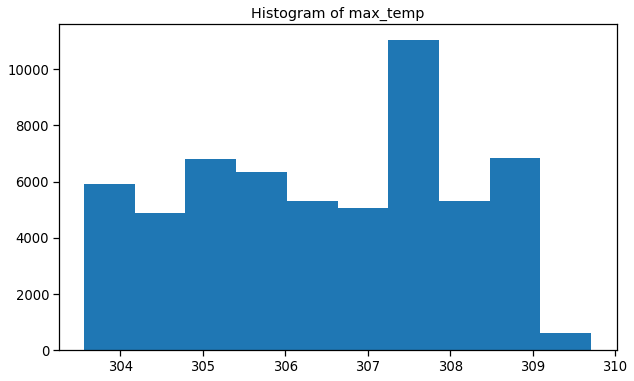

In [ ]:
plt.figure(figsize=(10, 6))
_ = plt.hist(csv_nona['max_temp'], bins=10)
plt.title('Histogram of max_temp')

Save the csv to file

In [ ]:
csv_nona.to_csv(f'daily_files/daily_{selected_date}.csv')